Обучить при помощи tf (keras) API любое ДЗ по обучениею классических моделей.<br>
Можно сдавать на торче.

In [1]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np


В качестве набора данных возьмем картинки лиц людей из домашней работы №15 с разрешением 62х47 в количестве 1456 штук. Для каждого человека укажем минимум 53 изображения. Количество классов - 10.

In [2]:
# download faces dataset
faces = fetch_lfw_people(min_faces_per_person=53)
data = faces.data
labels = faces.target

print(faces.images.shape)


(1456, 62, 47)


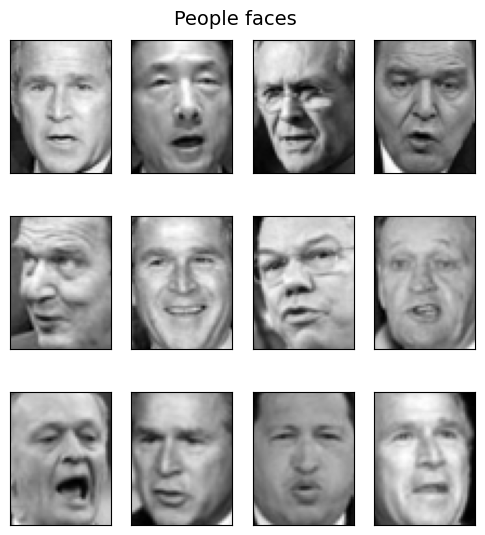

In [3]:
# show first 12 faces
fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(hspace=0.2, wspace=0.2, top=0.94)
fig.suptitle('People faces', fontsize=14)
plt.gray()

for i in range(12):
    ax = fig.add_subplot(3, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(faces.images[i])


In [4]:
# split dataset into train and test
train_data, test_data, train_labels, test_labels = train_test_split(data, labels,
                                                                    test_size=0.3)
print(train_data.shape, test_data.shape)


(1019, 2914) (437, 2914)


In [20]:
# initialize constants
INPUT_SHAPE = (data.shape[1],)
N_CLASSES = len(np.unique(labels))
DROPOUT_RATE = 0.2
N_HIDDEN = 4096
BATCH_SIZE = 64
VAL_SPLIT = 0.3
EPOCHS = 150


In [6]:
# encode labels
train_labels = tf.one_hot(train_labels, N_CLASSES)
test_labels = tf.one_hot(test_labels, N_CLASSES)

print(train_labels.shape, test_labels.shape)


(1019, 10) (437, 10)


In [21]:
# build tensorflow model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=INPUT_SHAPE))

model.add(tf.keras.layers.Dense(N_HIDDEN, activation='leaky_relu',
                                use_bias=True))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(DROPOUT_RATE))

model.add(tf.keras.layers.Dense(N_HIDDEN, activation='leaky_relu',
                                use_bias=True))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(DROPOUT_RATE))

model.add(tf.keras.layers.Dense(N_CLASSES, activation='softmax',
                                use_bias=True))

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 4096)                │      11,939,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 4096)                │          16,384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 4096)                │          16,384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │          40,970 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,794,890 (109.84 MB)

 Trainable params: 28,778,506 (109.78 MB)

 Non-trainable params: 16,384 (64.00 KB)

In [22]:
# create callbacks for saving model and reduce learning rate
model_saving = ModelCheckpoint('model_best.keras', save_best_only=True,
                               monitor='val_loss', mode='min')
lr_reducing = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10,
                                mode='min')


In [ ]:
# train model
history = model.fit(train_data, train_labels, batch_size=BATCH_SIZE,
                    epochs=EPOCHS, validation_split=VAL_SPLIT,
                    callbacks=[model_saving, lr_reducing])


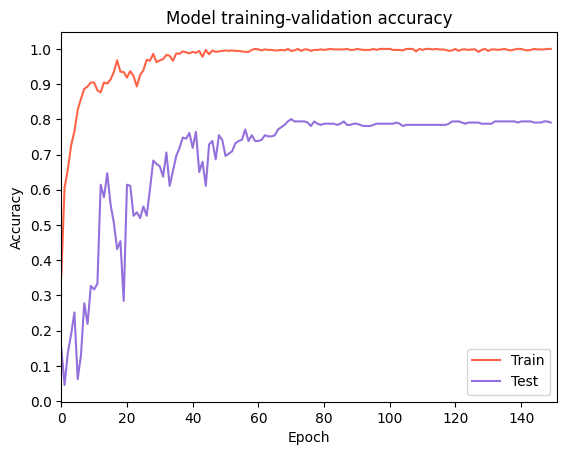

In [34]:
# show training curve
plt.plot(history.history['accuracy'], color='tomato')
plt.plot(history.history['val_accuracy'], color='mediumpurple')
plt.title('Model training-validation accuracy')
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(20))
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(0.1))
plt.xlim(0, EPOCHS + 1)
plt.legend(['Train', 'Test'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()


In [26]:
# load best model from saved .keras file
best_model = tf.keras.models.load_model('/content/model_best.keras')


In [29]:
# evaluate best model into test set
metrics = best_model.evaluate(test_data, test_labels)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7842 - loss: 1.5083 


В результате рботы с собственной нейронной сетью видно, что для данной архитектуры (из слоев Dense, Dropout, Activation) достаточно около 150 эпох, чтобы получить результат классификации ~78% на тестовой выборке. В процессе обучения колебания метрики val_accuracy практически выровнялись уже после 70ой эпохи.